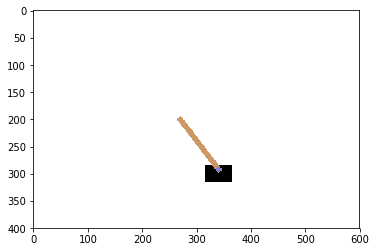

In [1]:
# import matplotlib.pyplot as plt
# import gym
# from IPython import display
# %matplotlib inline

# env = gym.make('CartPole-v0')
# env.reset()

# for i in range(25):
#    plt.imshow(env.render(mode='rgb_array'))
#    display.display(plt.gcf())    
#    display.clear_output(wait=True)
#    env.step(env.action_space.sample()) # take a random action

# env.close()

In [2]:
# The typical imports
# import gym
# import numpy as np
# import matplotlib.pyplot as plt
# %matplotlib inline

# # Imports specifically so we can render outputs in Jupyter.
# from JSAnimation.IPython_display import display_animation
# from matplotlib import animation
# from IPython.display import display


# def display_frames_as_gif(frames):
#     """
#     Displays a list of frames as a gif, with controls
#     """
#     #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
#     patch = plt.imshow(frames[0])
#     plt.axis('off')

#     def animate(i):
#         patch.set_data(frames[i])

#     anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
#     display(display_animation(anim, default_mode='loop'))

[2019-05-30 10:33:40,760] Making new env: CartPole-v0



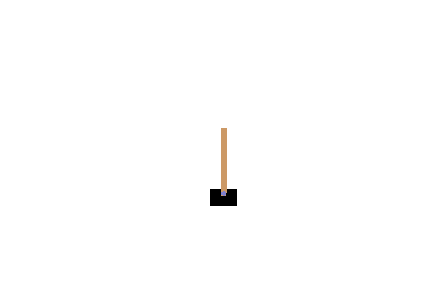
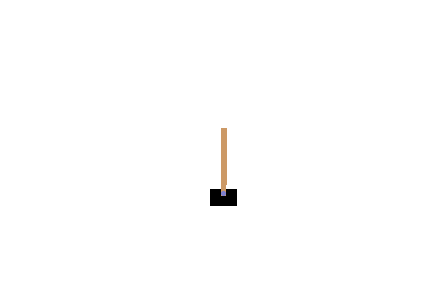
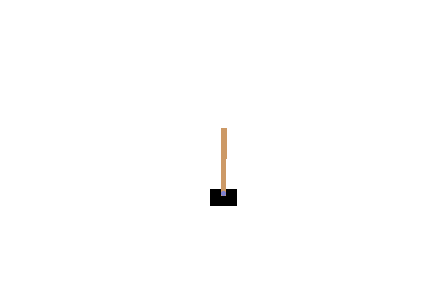
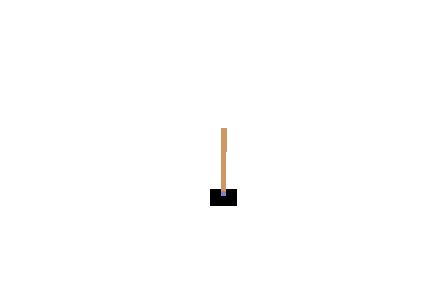
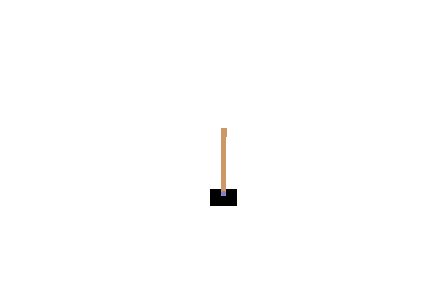
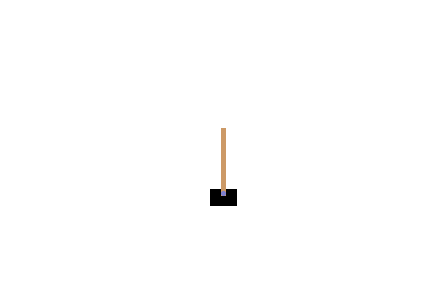
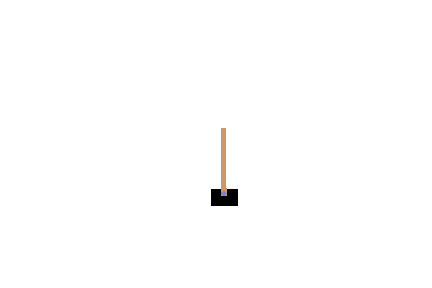
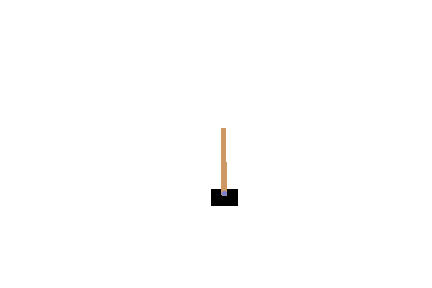
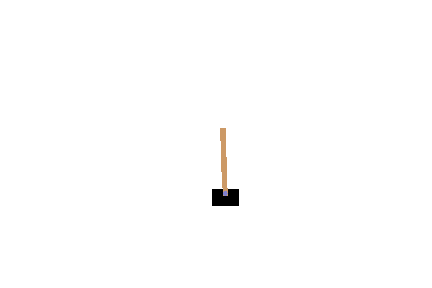
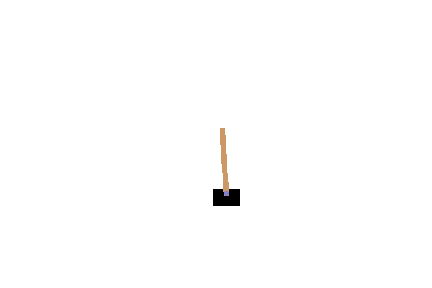
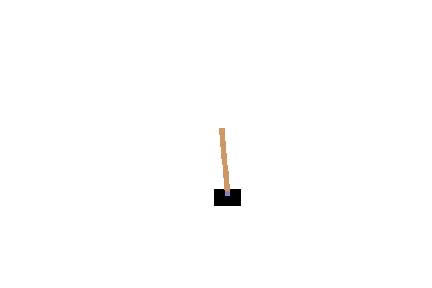
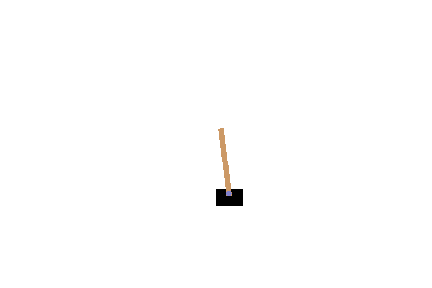
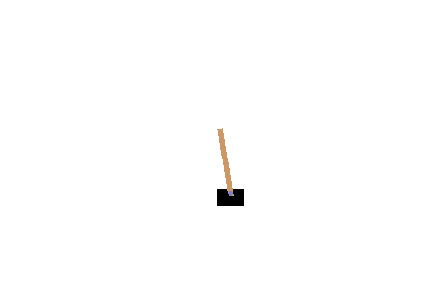
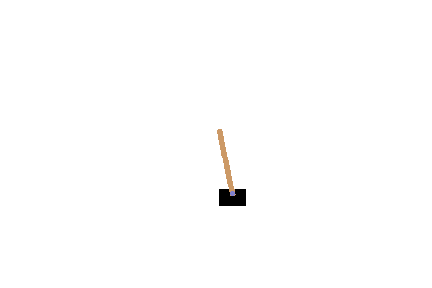

In [3]:
# env = gym.make('CartPole-v0')

# # Run a demo of the environment
# observation = env.reset()
# cum_reward = 0
# frames = []
# for t in range(5000):
#     # Render into buffer. 
#     frames.append(env.render(mode = 'rgb_array'))
#     action = env.action_space.sample()
#     observation, reward, done, info = env.step(action)
#     if done:
#         break
# env.render(close=True)
# display_frames_as_gif(frames)

## 1. Import

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## 2. Environment Intro
Ref: https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
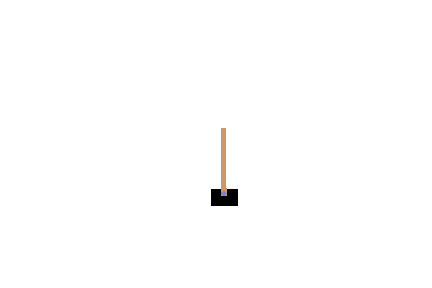
- Description: A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.
- Source: This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson.

- Observation: 

| Num | Observation | Min | Max |
|------|------|-----|-----|
|  0  | Cart Position | -4.8 | 4.8 |
|  1  | Cart Velocity | -Inf | Inf |
|  2  | Pole Angle | -24 deg | 24 deg |
|  3  | Pole Velocity At Tip | -Inf | Inf |

Note: Angle limit set to 2 * degree_threshold so failling observation is still within bounds

- Actions:

| Num | Action | 
|------|------|
|  0  | Push cart to the left |
|  1  | Push cart to the right |

- Reward: Reward is 1 for every step taken, including the termination step
- Starting State: All observations are assigned a uniform random value in [-0.05..0.05]
- Episode Termination:
    - Pole Angle is more than 12 degrees
    - Cart Position is more than 2.4 (center of the cart reaches the edge of the display)
    - Episode length is greater than 200
    - Solved Requirements: considered solved when the average reward is greater than or equal to 195.0 over 100 consecutive trials.

In [2]:
env = gym.make('CartPole-v0')

[2019-05-30 22:06:14,171] Making new env: CartPole-v0


In [3]:
obs = env.reset()
print(obs)

[-0.02209789  0.01823982 -0.03370487  0.01164254]


In [4]:
env.action_space

Discrete(2)

In [90]:
for _ in range(5):
    observation, reward, done, info = env.step(0)
    if done:
        env.reset()
    print(observation, reward, done, info)

[-0.03568025 -0.98103584  0.03002975  1.44046936] 1.0 False {}
[-0.05530097 -1.17651452  0.05883914  1.74238262] 1.0 False {}
[-0.07883126 -1.37225467  0.09368679  2.05277346] 1.0 False {}
[-0.10627635 -1.56820231  0.13474226  2.3729096 ] 1.0 False {}
[-0.1376404  -1.76423655  0.18220045  2.70379015] 1.0 False {}


## 3. Policy Gradient- REINFORCE
### 3-1 Policy Network

In [93]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(4, 8)
        self.fc1_1 = nn.Linear(8, 8)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 2)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc1_1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 3-2 Train

In [102]:
policy = PolicyNetwork()
optimizer = optim.Adam(policy.parameters(), lr=1e-4)
max_episodes = 1000
gamma = 1
reward_all_REINFORCE = []
for episode in range(max_episodes):
    rewards = []
    log_probs = []
    state = env.reset()
    while True:
        logits = policy(torch.FloatTensor([state]))
        probs = F.softmax(logits, dim=1)
        action = probs.multinomial(1) # Randomly select an action; Multinomial sampling is a weighted dice roll
        log_probs_ = F.log_softmax(logits, dim=1)
        log_prob = log_probs_.gather(1, action)
        
        state, reward, done, _ = env.step(action.item())
        rewards.append(reward)
        log_probs.append(log_prob)
        
        if done:
            Return = torch.zeros(1,1)
            for reward, log_prob in zip(reversed(rewards), reversed(log_probs)):
                Return = reward + gamma * Return
                loss = - log_prob * Return # Note: Negative value tranforms the maximizing problem to minimizing one
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            print("Episode: %d, reward %.1f" % (episode, np.sum(rewards)))
            reward_all_REINFORCE.append(np.sum(rewards))
            rewards = []
            log_probs = []
            break

Episode: 0, reward 10.0
Episode: 1, reward 53.0
Episode: 2, reward 16.0
Episode: 3, reward 11.0
Episode: 4, reward 11.0
Episode: 5, reward 21.0
Episode: 6, reward 14.0
Episode: 7, reward 11.0
Episode: 8, reward 12.0
Episode: 9, reward 17.0
Episode: 10, reward 25.0
Episode: 11, reward 10.0
Episode: 12, reward 12.0
Episode: 13, reward 11.0
Episode: 14, reward 12.0
Episode: 15, reward 23.0
Episode: 16, reward 25.0
Episode: 17, reward 18.0
Episode: 18, reward 10.0
Episode: 19, reward 17.0
Episode: 20, reward 19.0
Episode: 21, reward 17.0
Episode: 22, reward 14.0
Episode: 23, reward 17.0
Episode: 24, reward 23.0
Episode: 25, reward 18.0
Episode: 26, reward 13.0
Episode: 27, reward 22.0
Episode: 28, reward 15.0
Episode: 29, reward 9.0
Episode: 30, reward 13.0
Episode: 31, reward 15.0
Episode: 32, reward 30.0
Episode: 33, reward 18.0
Episode: 34, reward 34.0
Episode: 35, reward 18.0
Episode: 36, reward 42.0
Episode: 37, reward 16.0
Episode: 38, reward 13.0
Episode: 39, reward 26.0
Episode: 40

Episode: 329, reward 50.0
Episode: 330, reward 12.0
Episode: 331, reward 33.0
Episode: 332, reward 19.0
Episode: 333, reward 16.0
Episode: 334, reward 17.0
Episode: 335, reward 15.0
Episode: 336, reward 12.0
Episode: 337, reward 16.0
Episode: 338, reward 26.0
Episode: 339, reward 12.0
Episode: 340, reward 12.0
Episode: 341, reward 12.0
Episode: 342, reward 14.0
Episode: 343, reward 10.0
Episode: 344, reward 28.0
Episode: 345, reward 13.0
Episode: 346, reward 63.0
Episode: 347, reward 12.0
Episode: 348, reward 17.0
Episode: 349, reward 14.0
Episode: 350, reward 15.0
Episode: 351, reward 20.0
Episode: 352, reward 22.0
Episode: 353, reward 48.0
Episode: 354, reward 13.0
Episode: 355, reward 12.0
Episode: 356, reward 14.0
Episode: 357, reward 17.0
Episode: 358, reward 18.0
Episode: 359, reward 29.0
Episode: 360, reward 17.0
Episode: 361, reward 24.0
Episode: 362, reward 47.0
Episode: 363, reward 16.0
Episode: 364, reward 50.0
Episode: 365, reward 23.0
Episode: 366, reward 21.0
Episode: 367

Episode: 650, reward 24.0
Episode: 651, reward 35.0
Episode: 652, reward 16.0
Episode: 653, reward 18.0
Episode: 654, reward 15.0
Episode: 655, reward 15.0
Episode: 656, reward 28.0
Episode: 657, reward 23.0
Episode: 658, reward 15.0
Episode: 659, reward 16.0
Episode: 660, reward 13.0
Episode: 661, reward 39.0
Episode: 662, reward 13.0
Episode: 663, reward 46.0
Episode: 664, reward 16.0
Episode: 665, reward 24.0
Episode: 666, reward 19.0
Episode: 667, reward 29.0
Episode: 668, reward 36.0
Episode: 669, reward 60.0
Episode: 670, reward 11.0
Episode: 671, reward 49.0
Episode: 672, reward 13.0
Episode: 673, reward 13.0
Episode: 674, reward 17.0
Episode: 675, reward 11.0
Episode: 676, reward 18.0
Episode: 677, reward 37.0
Episode: 678, reward 14.0
Episode: 679, reward 17.0
Episode: 680, reward 23.0
Episode: 681, reward 44.0
Episode: 682, reward 21.0
Episode: 683, reward 34.0
Episode: 684, reward 60.0
Episode: 685, reward 28.0
Episode: 686, reward 48.0
Episode: 687, reward 56.0
Episode: 688

Episode: 973, reward 27.0
Episode: 974, reward 11.0
Episode: 975, reward 30.0
Episode: 976, reward 35.0
Episode: 977, reward 38.0
Episode: 978, reward 44.0
Episode: 979, reward 33.0
Episode: 980, reward 25.0
Episode: 981, reward 70.0
Episode: 982, reward 17.0
Episode: 983, reward 19.0
Episode: 984, reward 11.0
Episode: 985, reward 72.0
Episode: 986, reward 24.0
Episode: 987, reward 54.0
Episode: 988, reward 28.0
Episode: 989, reward 17.0
Episode: 990, reward 55.0
Episode: 991, reward 49.0
Episode: 992, reward 51.0
Episode: 993, reward 21.0
Episode: 994, reward 45.0
Episode: 995, reward 27.0
Episode: 996, reward 43.0
Episode: 997, reward 24.0
Episode: 998, reward 35.0
Episode: 999, reward 12.0


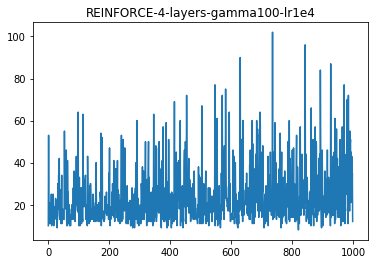

In [103]:
plt.plot(reward_all_REINFORCE)
plt.title('REINFORCE-4-layers-gamma100-lr1e4')
plt.show()

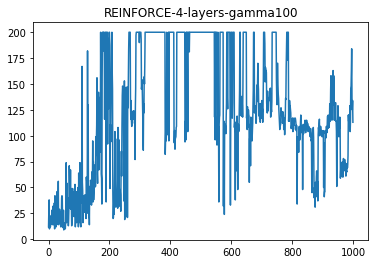

In [101]:
plt.plot(reward_all_REINFORCE)
plt.title('REINFORCE-4-layers-gamma100')
plt.show()

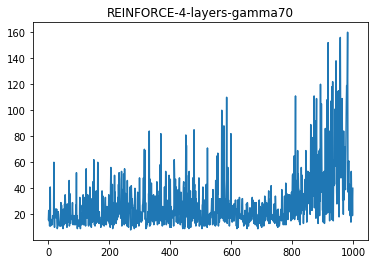

In [99]:
plt.plot(reward_all_REINFORCE)
plt.title('REINFORCE-4-layers-gamma70')
plt.show()

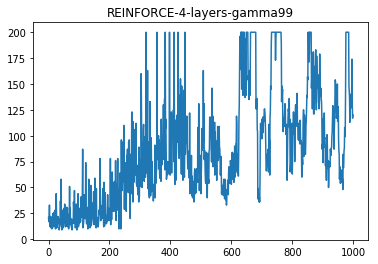

In [97]:
plt.plot(reward_all_REINFORCE)
plt.title('REINFORCE-4-layers-gamma99')
plt.show()

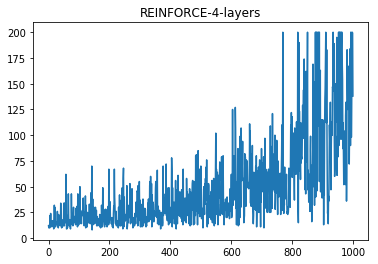

In [95]:
plt.plot(reward_all_REINFORCE)
plt.title('REINFORCE-4-layers')
plt.show()

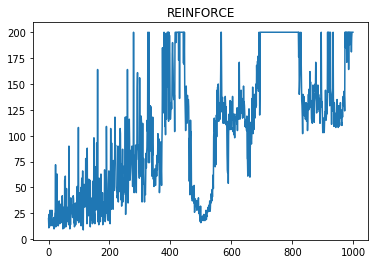

In [92]:
plt.plot(reward_all_REINFORCE)
plt.title('REINFORCE')
plt.show()

## 4. Q Actor-Critic

### 4-1 Q Network

In [61]:
class ActionValueNetwork(nn.Module):
    def __init__(self):
        super(ActionValueNetwork, self).__init__()
        self.fc1 = nn.Linear(4, 8)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 2)
    def forward(self, x):
        x = F.relu(self.fc1(x))
#         x = F.relu(self.fc1_1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 4-2 Q Actor Critic Alg

In [62]:
def q_ac(num_steps, max_episodes):
    policy_network = PolicyNetwork()
    action_value_network = ActionValueNetwork()
    optimizer_policy = optim.Adam(policy_network.parameters(), lr=1e-3)
    optimizer_action_value = optim.Adam(action_value_network.parameters(), lr=1e-3)
    max_episodes = max_episodes
    num_steps = num_steps
    gamma = 0.9
    reward_all = []
    for episode in range(max_episodes):
        rewards = []
        log_probs = []
        action_values = []
        state = env.reset()
        step = 0
        while True:
            logits = policy_network(torch.FloatTensor([state]))
            probs = F.softmax(logits, dim=1)
            action = probs.multinomial(1) # Randomly select an action; Multinomial sampling is a weighted dice roll
            log_probs_ = F.log_softmax(logits, dim=1)
            log_prob = log_probs_.gather(1, action)
            action_value = action_value_network(torch.FloatTensor([state])).gather(1, action)
            state, reward, done, _ = env.step(action.item())
            rewards.append(reward)
            log_probs.append(log_prob)
            action_values.append(action_value)
            step += 1
        
            if step >= num_steps or done:
                Return = torch.zeros(1,1)
                if done:
                    next_action_value = torch.zeros(1,1)
                else:
                    logits = policy_network(torch.FloatTensor([state]))
                    probs = F.softmax(logits, dim=1)
                    action = probs.multinomial(1) # Randomly select an action;
                    next_action_value = action_value_network(torch.FloatTensor([state])).gather(1, action)
                for reward, log_prob, action_value in zip(reversed(rewards), reversed(log_probs), reversed(action_values)):
                    Return = reward + gamma * Return
                    action_value_loss = (Return + (gamma ** step) * next_action_value - action_value).pow(2)
                    # Huber loss
#                 action_value_loss = F.smooth_l1_loss(action_value, Return + (gamma ** step) * next_action_value)
                    policy_loss = - log_prob * action_value
                
                    optimizer_action_value.zero_grad()
                    optimizer_policy.zero_grad()
                    action_value_loss.backward(retain_graph=True)
                    policy_loss.backward(retain_graph=True)
                    optimizer_action_value.step()
                    optimizer_policy.step()
            if done:
                print("Episode: %d, reward %.1f" % (episode, np.sum(rewards)))
                reward_all.append(np.sum(rewards))
                rewards = []
                log_probs = []
                break
    return reward_all

### 4-3 TD(0) Q Actor Critic

In [63]:
reward_all_q_0 = q_ac(0, 1000)

Episode: 0, reward 13.0
Episode: 1, reward 22.0
Episode: 2, reward 15.0
Episode: 3, reward 8.0
Episode: 4, reward 14.0
Episode: 5, reward 13.0
Episode: 6, reward 11.0
Episode: 7, reward 13.0
Episode: 8, reward 10.0
Episode: 9, reward 8.0
Episode: 10, reward 12.0
Episode: 11, reward 10.0
Episode: 12, reward 9.0
Episode: 13, reward 11.0
Episode: 14, reward 8.0
Episode: 15, reward 11.0
Episode: 16, reward 14.0
Episode: 17, reward 10.0
Episode: 18, reward 10.0
Episode: 19, reward 9.0
Episode: 20, reward 14.0
Episode: 21, reward 10.0
Episode: 22, reward 11.0
Episode: 23, reward 11.0
Episode: 24, reward 15.0
Episode: 25, reward 11.0
Episode: 26, reward 10.0
Episode: 27, reward 10.0
Episode: 28, reward 9.0
Episode: 29, reward 9.0
Episode: 30, reward 12.0
Episode: 31, reward 21.0
Episode: 32, reward 10.0
Episode: 33, reward 34.0
Episode: 34, reward 17.0
Episode: 35, reward 17.0
Episode: 36, reward 26.0
Episode: 37, reward 25.0
Episode: 38, reward 23.0
Episode: 39, reward 17.0
Episode: 40, rewa

Episode: 323, reward 8.0
Episode: 324, reward 9.0
Episode: 325, reward 10.0
Episode: 326, reward 9.0
Episode: 327, reward 9.0
Episode: 328, reward 9.0
Episode: 329, reward 9.0
Episode: 330, reward 8.0
Episode: 331, reward 10.0
Episode: 332, reward 9.0
Episode: 333, reward 10.0
Episode: 334, reward 10.0
Episode: 335, reward 10.0
Episode: 336, reward 9.0
Episode: 337, reward 8.0
Episode: 338, reward 8.0
Episode: 339, reward 8.0
Episode: 340, reward 9.0
Episode: 341, reward 9.0
Episode: 342, reward 10.0
Episode: 343, reward 9.0
Episode: 344, reward 9.0
Episode: 345, reward 9.0
Episode: 346, reward 9.0
Episode: 347, reward 10.0
Episode: 348, reward 9.0
Episode: 349, reward 8.0
Episode: 350, reward 9.0
Episode: 351, reward 9.0
Episode: 352, reward 8.0
Episode: 353, reward 8.0
Episode: 354, reward 9.0
Episode: 355, reward 10.0
Episode: 356, reward 10.0
Episode: 357, reward 9.0
Episode: 358, reward 9.0
Episode: 359, reward 8.0
Episode: 360, reward 9.0
Episode: 361, reward 10.0
Episode: 362, r

Episode: 646, reward 10.0
Episode: 647, reward 8.0
Episode: 648, reward 9.0
Episode: 649, reward 9.0
Episode: 650, reward 9.0
Episode: 651, reward 9.0
Episode: 652, reward 10.0
Episode: 653, reward 8.0
Episode: 654, reward 10.0
Episode: 655, reward 10.0
Episode: 656, reward 10.0
Episode: 657, reward 9.0
Episode: 658, reward 10.0
Episode: 659, reward 10.0
Episode: 660, reward 11.0
Episode: 661, reward 10.0
Episode: 662, reward 8.0
Episode: 663, reward 9.0
Episode: 664, reward 10.0
Episode: 665, reward 9.0
Episode: 666, reward 9.0
Episode: 667, reward 9.0
Episode: 668, reward 8.0
Episode: 669, reward 9.0
Episode: 670, reward 8.0
Episode: 671, reward 9.0
Episode: 672, reward 9.0
Episode: 673, reward 9.0
Episode: 674, reward 9.0
Episode: 675, reward 10.0
Episode: 676, reward 10.0
Episode: 677, reward 9.0
Episode: 678, reward 10.0
Episode: 679, reward 9.0
Episode: 680, reward 9.0
Episode: 681, reward 9.0
Episode: 682, reward 8.0
Episode: 683, reward 9.0
Episode: 684, reward 9.0
Episode: 685

Episode: 971, reward 10.0
Episode: 972, reward 10.0
Episode: 973, reward 10.0
Episode: 974, reward 9.0
Episode: 975, reward 10.0
Episode: 976, reward 10.0
Episode: 977, reward 9.0
Episode: 978, reward 10.0
Episode: 979, reward 10.0
Episode: 980, reward 8.0
Episode: 981, reward 10.0
Episode: 982, reward 10.0
Episode: 983, reward 10.0
Episode: 984, reward 10.0
Episode: 985, reward 10.0
Episode: 986, reward 8.0
Episode: 987, reward 10.0
Episode: 988, reward 9.0
Episode: 989, reward 9.0
Episode: 990, reward 9.0
Episode: 991, reward 10.0
Episode: 992, reward 8.0
Episode: 993, reward 8.0
Episode: 994, reward 10.0
Episode: 995, reward 9.0
Episode: 996, reward 9.0
Episode: 997, reward 10.0
Episode: 998, reward 9.0
Episode: 999, reward 9.0


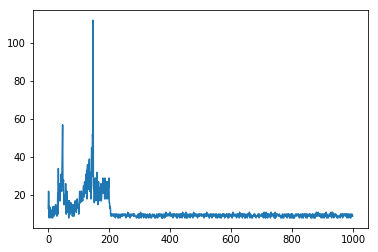

In [64]:
plt.plot(reward_all_q_0)
plt.show()

### 4-4 TD(50) Q Actor Critic

In [65]:
reward_all_q_50 = q_ac(50, 1000)

Episode: 0, reward 25.0
Episode: 1, reward 12.0
Episode: 2, reward 31.0
Episode: 3, reward 13.0
Episode: 4, reward 24.0
Episode: 5, reward 20.0
Episode: 6, reward 9.0
Episode: 7, reward 13.0
Episode: 8, reward 11.0
Episode: 9, reward 12.0
Episode: 10, reward 14.0
Episode: 11, reward 11.0
Episode: 12, reward 10.0
Episode: 13, reward 8.0
Episode: 14, reward 9.0
Episode: 15, reward 9.0
Episode: 16, reward 10.0
Episode: 17, reward 9.0
Episode: 18, reward 9.0
Episode: 19, reward 9.0
Episode: 20, reward 9.0
Episode: 21, reward 10.0
Episode: 22, reward 10.0
Episode: 23, reward 10.0
Episode: 24, reward 10.0
Episode: 25, reward 9.0
Episode: 26, reward 9.0
Episode: 27, reward 10.0
Episode: 28, reward 8.0
Episode: 29, reward 9.0
Episode: 30, reward 10.0
Episode: 31, reward 10.0
Episode: 32, reward 10.0
Episode: 33, reward 10.0
Episode: 34, reward 9.0
Episode: 35, reward 10.0
Episode: 36, reward 10.0
Episode: 37, reward 10.0
Episode: 38, reward 10.0
Episode: 39, reward 9.0
Episode: 40, reward 9.0


Episode: 337, reward 9.0
Episode: 338, reward 10.0
Episode: 339, reward 9.0
Episode: 340, reward 10.0
Episode: 341, reward 9.0
Episode: 342, reward 8.0
Episode: 343, reward 10.0
Episode: 344, reward 10.0
Episode: 345, reward 9.0
Episode: 346, reward 10.0
Episode: 347, reward 9.0
Episode: 348, reward 10.0
Episode: 349, reward 9.0
Episode: 350, reward 9.0
Episode: 351, reward 8.0
Episode: 352, reward 10.0
Episode: 353, reward 9.0
Episode: 354, reward 9.0
Episode: 355, reward 10.0
Episode: 356, reward 10.0
Episode: 357, reward 9.0
Episode: 358, reward 8.0
Episode: 359, reward 8.0
Episode: 360, reward 10.0
Episode: 361, reward 9.0
Episode: 362, reward 10.0
Episode: 363, reward 9.0
Episode: 364, reward 9.0
Episode: 365, reward 8.0
Episode: 366, reward 10.0
Episode: 367, reward 10.0
Episode: 368, reward 10.0
Episode: 369, reward 9.0
Episode: 370, reward 10.0
Episode: 371, reward 9.0
Episode: 372, reward 10.0
Episode: 373, reward 10.0
Episode: 374, reward 9.0
Episode: 375, reward 10.0
Episode

Episode: 674, reward 9.0
Episode: 675, reward 9.0
Episode: 676, reward 10.0
Episode: 677, reward 8.0
Episode: 678, reward 10.0
Episode: 679, reward 10.0
Episode: 680, reward 10.0
Episode: 681, reward 10.0
Episode: 682, reward 9.0
Episode: 683, reward 10.0
Episode: 684, reward 10.0
Episode: 685, reward 9.0
Episode: 686, reward 10.0
Episode: 687, reward 9.0
Episode: 688, reward 10.0
Episode: 689, reward 9.0
Episode: 690, reward 10.0
Episode: 691, reward 10.0
Episode: 692, reward 9.0
Episode: 693, reward 9.0
Episode: 694, reward 10.0
Episode: 695, reward 9.0
Episode: 696, reward 10.0
Episode: 697, reward 10.0
Episode: 698, reward 8.0
Episode: 699, reward 10.0
Episode: 700, reward 9.0
Episode: 701, reward 10.0
Episode: 702, reward 10.0
Episode: 703, reward 8.0
Episode: 704, reward 10.0
Episode: 705, reward 10.0
Episode: 706, reward 10.0
Episode: 707, reward 10.0
Episode: 708, reward 9.0
Episode: 709, reward 9.0
Episode: 710, reward 10.0
Episode: 711, reward 9.0
Episode: 712, reward 9.0
Epi

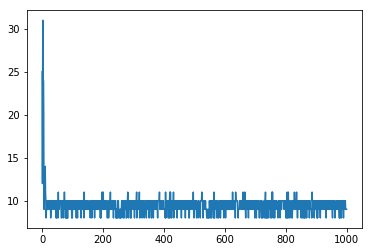

In [66]:
plt.plot(reward_all_q_50)
plt.show()

### 4-5 TD(100) Q Actor Critic


In [67]:
reward_all_q_100 = q_ac(100, 1000)

Episode: 0, reward 21.0
Episode: 1, reward 19.0
Episode: 2, reward 12.0
Episode: 3, reward 30.0
Episode: 4, reward 13.0
Episode: 5, reward 17.0
Episode: 6, reward 10.0
Episode: 7, reward 19.0
Episode: 8, reward 16.0
Episode: 9, reward 30.0
Episode: 10, reward 12.0
Episode: 11, reward 27.0
Episode: 12, reward 14.0
Episode: 13, reward 21.0
Episode: 14, reward 8.0
Episode: 15, reward 11.0
Episode: 16, reward 10.0
Episode: 17, reward 14.0
Episode: 18, reward 9.0
Episode: 19, reward 10.0
Episode: 20, reward 13.0
Episode: 21, reward 13.0
Episode: 22, reward 11.0
Episode: 23, reward 10.0
Episode: 24, reward 9.0
Episode: 25, reward 11.0
Episode: 26, reward 11.0
Episode: 27, reward 9.0
Episode: 28, reward 10.0
Episode: 29, reward 9.0
Episode: 30, reward 10.0
Episode: 31, reward 10.0
Episode: 32, reward 9.0
Episode: 33, reward 12.0
Episode: 34, reward 10.0
Episode: 35, reward 11.0
Episode: 36, reward 8.0
Episode: 37, reward 10.0
Episode: 38, reward 10.0
Episode: 39, reward 10.0
Episode: 40, rewa

Episode: 327, reward 10.0
Episode: 328, reward 8.0
Episode: 329, reward 9.0
Episode: 330, reward 10.0
Episode: 331, reward 9.0
Episode: 332, reward 9.0
Episode: 333, reward 9.0
Episode: 334, reward 10.0
Episode: 335, reward 9.0
Episode: 336, reward 9.0
Episode: 337, reward 9.0
Episode: 338, reward 9.0
Episode: 339, reward 11.0
Episode: 340, reward 9.0
Episode: 341, reward 11.0
Episode: 342, reward 9.0
Episode: 343, reward 8.0
Episode: 344, reward 10.0
Episode: 345, reward 8.0
Episode: 346, reward 10.0
Episode: 347, reward 8.0
Episode: 348, reward 9.0
Episode: 349, reward 10.0
Episode: 350, reward 10.0
Episode: 351, reward 8.0
Episode: 352, reward 8.0
Episode: 353, reward 10.0
Episode: 354, reward 10.0
Episode: 355, reward 10.0
Episode: 356, reward 10.0
Episode: 357, reward 8.0
Episode: 358, reward 9.0
Episode: 359, reward 9.0
Episode: 360, reward 10.0
Episode: 361, reward 10.0
Episode: 362, reward 11.0
Episode: 363, reward 10.0
Episode: 364, reward 10.0
Episode: 365, reward 9.0
Episode

Episode: 650, reward 9.0
Episode: 651, reward 10.0
Episode: 652, reward 10.0
Episode: 653, reward 9.0
Episode: 654, reward 11.0
Episode: 655, reward 8.0
Episode: 656, reward 10.0
Episode: 657, reward 10.0
Episode: 658, reward 10.0
Episode: 659, reward 10.0
Episode: 660, reward 8.0
Episode: 661, reward 10.0
Episode: 662, reward 9.0
Episode: 663, reward 10.0
Episode: 664, reward 9.0
Episode: 665, reward 9.0
Episode: 666, reward 10.0
Episode: 667, reward 9.0
Episode: 668, reward 8.0
Episode: 669, reward 9.0
Episode: 670, reward 10.0
Episode: 671, reward 9.0
Episode: 672, reward 10.0
Episode: 673, reward 10.0
Episode: 674, reward 8.0
Episode: 675, reward 9.0
Episode: 676, reward 9.0
Episode: 677, reward 9.0
Episode: 678, reward 10.0
Episode: 679, reward 10.0
Episode: 680, reward 9.0
Episode: 681, reward 9.0
Episode: 682, reward 10.0
Episode: 683, reward 10.0
Episode: 684, reward 10.0
Episode: 685, reward 8.0
Episode: 686, reward 8.0
Episode: 687, reward 10.0
Episode: 688, reward 10.0
Episo

Episode: 985, reward 10.0
Episode: 986, reward 10.0
Episode: 987, reward 10.0
Episode: 988, reward 10.0
Episode: 989, reward 11.0
Episode: 990, reward 10.0
Episode: 991, reward 8.0
Episode: 992, reward 10.0
Episode: 993, reward 8.0
Episode: 994, reward 9.0
Episode: 995, reward 8.0
Episode: 996, reward 10.0
Episode: 997, reward 8.0
Episode: 998, reward 10.0
Episode: 999, reward 9.0


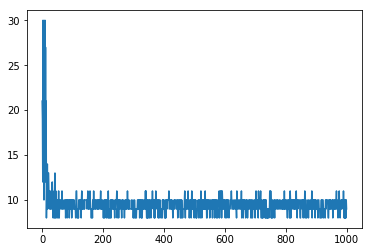

In [68]:
plt.plot(reward_all_q_100)
plt.show()

### 4-6 TD(200) Q Actor Critic


In [73]:
reward_all_q_200 = q_ac(200, 1000)

Episode: 0, reward 13.0
Episode: 1, reward 21.0
Episode: 2, reward 8.0
Episode: 3, reward 43.0
Episode: 4, reward 15.0
Episode: 5, reward 19.0
Episode: 6, reward 12.0
Episode: 7, reward 13.0
Episode: 8, reward 17.0
Episode: 9, reward 9.0
Episode: 10, reward 15.0
Episode: 11, reward 8.0
Episode: 12, reward 10.0
Episode: 13, reward 11.0
Episode: 14, reward 10.0
Episode: 15, reward 11.0
Episode: 16, reward 12.0
Episode: 17, reward 10.0
Episode: 18, reward 10.0
Episode: 19, reward 11.0
Episode: 20, reward 10.0
Episode: 21, reward 9.0
Episode: 22, reward 10.0
Episode: 23, reward 11.0
Episode: 24, reward 10.0
Episode: 25, reward 12.0
Episode: 26, reward 12.0
Episode: 27, reward 8.0
Episode: 28, reward 10.0
Episode: 29, reward 11.0
Episode: 30, reward 10.0
Episode: 31, reward 9.0
Episode: 32, reward 9.0
Episode: 33, reward 10.0
Episode: 34, reward 10.0
Episode: 35, reward 10.0
Episode: 36, reward 8.0
Episode: 37, reward 10.0
Episode: 38, reward 9.0
Episode: 39, reward 9.0
Episode: 40, reward 

Episode: 343, reward 9.0
Episode: 344, reward 9.0
Episode: 345, reward 9.0
Episode: 346, reward 9.0
Episode: 347, reward 8.0
Episode: 348, reward 8.0
Episode: 349, reward 9.0
Episode: 350, reward 10.0
Episode: 351, reward 8.0
Episode: 352, reward 10.0
Episode: 353, reward 8.0
Episode: 354, reward 10.0
Episode: 355, reward 10.0
Episode: 356, reward 9.0
Episode: 357, reward 10.0
Episode: 358, reward 8.0
Episode: 359, reward 10.0
Episode: 360, reward 10.0
Episode: 361, reward 10.0
Episode: 362, reward 10.0
Episode: 363, reward 9.0
Episode: 364, reward 10.0
Episode: 365, reward 10.0
Episode: 366, reward 8.0
Episode: 367, reward 10.0
Episode: 368, reward 9.0
Episode: 369, reward 8.0
Episode: 370, reward 8.0
Episode: 371, reward 9.0
Episode: 372, reward 9.0
Episode: 373, reward 11.0
Episode: 374, reward 10.0
Episode: 375, reward 8.0
Episode: 376, reward 11.0
Episode: 377, reward 9.0
Episode: 378, reward 10.0
Episode: 379, reward 10.0
Episode: 380, reward 10.0
Episode: 381, reward 9.0
Episode

Episode: 670, reward 9.0
Episode: 671, reward 9.0
Episode: 672, reward 10.0
Episode: 673, reward 10.0
Episode: 674, reward 10.0
Episode: 675, reward 10.0
Episode: 676, reward 10.0
Episode: 677, reward 9.0
Episode: 678, reward 8.0
Episode: 679, reward 8.0
Episode: 680, reward 9.0
Episode: 681, reward 10.0
Episode: 682, reward 10.0
Episode: 683, reward 10.0
Episode: 684, reward 9.0
Episode: 685, reward 9.0
Episode: 686, reward 9.0
Episode: 687, reward 10.0
Episode: 688, reward 10.0
Episode: 689, reward 9.0
Episode: 690, reward 9.0
Episode: 691, reward 9.0
Episode: 692, reward 10.0
Episode: 693, reward 10.0
Episode: 694, reward 9.0
Episode: 695, reward 8.0
Episode: 696, reward 9.0
Episode: 697, reward 8.0
Episode: 698, reward 10.0
Episode: 699, reward 10.0
Episode: 700, reward 10.0
Episode: 701, reward 9.0
Episode: 702, reward 9.0
Episode: 703, reward 9.0
Episode: 704, reward 8.0
Episode: 705, reward 10.0
Episode: 706, reward 10.0
Episode: 707, reward 10.0
Episode: 708, reward 10.0
Episod

Episode: 994, reward 11.0
Episode: 995, reward 10.0
Episode: 996, reward 9.0
Episode: 997, reward 11.0
Episode: 998, reward 9.0
Episode: 999, reward 10.0


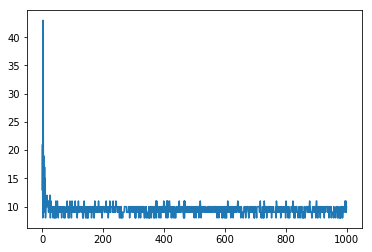

In [74]:
plt.plot(reward_all_q_200)
plt.show()

## 5. Advantage Actor-Critic

### 5-1 Value Network

In [41]:
class StateValueNetwork(nn.Module):
    def __init__(self):
        super(StateValueNetwork, self).__init__()
        self.fc1 = nn.Linear(4, 8)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 5-2 Advantage Actor Critic Alg

In [48]:
def adv_ac(num_steps, max_episodes):
    policy_network = PolicyNetwork()
    state_value_network = StateValueNetwork()
    optimizer_policy = optim.Adam(policy_network.parameters(), lr=1e-3)
    optimizer_state_value = optim.Adam(state_value_network.parameters(), lr=1e-4)
    max_episodes = max_episodes
    num_steps = num_steps
    gamma = 0.9
    reward_all = []
    for episode in range(max_episodes):
        rewards = []
        log_probs = []
        state_values = []
        state = env.reset()
        step = 0
        while True:
            logits = policy_network(torch.FloatTensor([state]))
            probs = F.softmax(logits, dim=1)
            action = probs.multinomial(1) # Randomly select an action; Multinomial sampling is a weighted dice roll
            log_probs_ = F.log_softmax(logits, dim=1)
            log_prob = log_probs_.gather(1, action)
            state_value = state_value_network(torch.FloatTensor([state]))
            state, reward, done, _ = env.step(action.item())
            rewards.append(reward)
            log_probs.append(log_prob)
            state_values.append(state_value)
            step += 1
        
            if step >= num_steps or done:
                Return = torch.zeros(1,1)
                if done:
                    next_state_value = torch.zeros(1,1)
                else:
                    logits = policy_network(torch.FloatTensor([state]))
                    probs = F.softmax(logits, dim=1)
                    action = probs.multinomial(1) # Randomly select an action;
                    state, reward, done, _ = env.step(action.item())
                    next_state_value = state_value_network(torch.FloatTensor([state]))
                for reward, log_prob, state_value in zip(reversed(rewards), reversed(log_probs), reversed(state_values)):
                    Return = reward + gamma * Return
                    advantage = Return + (gamma ** step) * next_state_value - state_value
                    policy_loss = - log_prob * advantage
                
                    optimizer_state_value.zero_grad()
                    optimizer_policy.zero_grad()
                    state_value_loss = advantage.pow(2) ## Advantage.pow(1) doesn't work! ???
                    state_value_loss.backward(retain_graph=True)
                    policy_loss.backward(retain_graph=True)
                    optimizer_state_value.step()
                    optimizer_policy.step()
            if done:
                print("Episode: %d, reward %.1f" % (episode, np.sum(rewards)))
                reward_all.append(np.sum(rewards))
                rewards = []
                log_probs = []
                break
    return reward_all

### 5-3 TD(0) Advantage Actor-Critic

In [49]:
reward_all_0 = adv_ac(num_steps=0, max_episodes=1000)

Episode: 0, reward 25.0
Episode: 1, reward 23.0
Episode: 2, reward 34.0
Episode: 3, reward 10.0
Episode: 4, reward 7.0
Episode: 5, reward 8.0
Episode: 6, reward 7.0
Episode: 7, reward 10.0
Episode: 8, reward 24.0
Episode: 9, reward 7.0
Episode: 10, reward 7.0
Episode: 11, reward 20.0
Episode: 12, reward 15.0
Episode: 13, reward 26.0
Episode: 14, reward 12.0
Episode: 15, reward 28.0
Episode: 16, reward 18.0
Episode: 17, reward 11.0
Episode: 18, reward 46.0
Episode: 19, reward 8.0
Episode: 20, reward 6.0
Episode: 21, reward 7.0
Episode: 22, reward 6.0
Episode: 23, reward 6.0
Episode: 24, reward 5.0
Episode: 25, reward 7.0
Episode: 26, reward 8.0
Episode: 27, reward 7.0
Episode: 28, reward 6.0
Episode: 29, reward 5.0
Episode: 30, reward 6.0
Episode: 31, reward 4.0
Episode: 32, reward 5.0
Episode: 33, reward 6.0
Episode: 34, reward 7.0
Episode: 35, reward 6.0
Episode: 36, reward 7.0
Episode: 37, reward 5.0
Episode: 38, reward 5.0
Episode: 39, reward 8.0
Episode: 40, reward 5.0
Episode: 41,

Episode: 333, reward 5.0
Episode: 334, reward 5.0
Episode: 335, reward 5.0
Episode: 336, reward 5.0
Episode: 337, reward 5.0
Episode: 338, reward 5.0
Episode: 339, reward 5.0
Episode: 340, reward 5.0
Episode: 341, reward 5.0
Episode: 342, reward 5.0
Episode: 343, reward 4.0
Episode: 344, reward 5.0
Episode: 345, reward 4.0
Episode: 346, reward 5.0
Episode: 347, reward 5.0
Episode: 348, reward 5.0
Episode: 349, reward 5.0
Episode: 350, reward 6.0
Episode: 351, reward 5.0
Episode: 352, reward 5.0
Episode: 353, reward 5.0
Episode: 354, reward 5.0
Episode: 355, reward 5.0
Episode: 356, reward 6.0
Episode: 357, reward 4.0
Episode: 358, reward 5.0
Episode: 359, reward 5.0
Episode: 360, reward 5.0
Episode: 361, reward 4.0
Episode: 362, reward 5.0
Episode: 363, reward 5.0
Episode: 364, reward 5.0
Episode: 365, reward 5.0
Episode: 366, reward 5.0
Episode: 367, reward 5.0
Episode: 368, reward 5.0
Episode: 369, reward 5.0
Episode: 370, reward 5.0
Episode: 371, reward 6.0
Episode: 372, reward 5.0


Episode: 661, reward 7.0
Episode: 662, reward 6.0
Episode: 663, reward 6.0
Episode: 664, reward 6.0
Episode: 665, reward 8.0
Episode: 666, reward 8.0
Episode: 667, reward 7.0
Episode: 668, reward 7.0
Episode: 669, reward 6.0
Episode: 670, reward 6.0
Episode: 671, reward 8.0
Episode: 672, reward 5.0
Episode: 673, reward 6.0
Episode: 674, reward 9.0
Episode: 675, reward 9.0
Episode: 676, reward 6.0
Episode: 677, reward 6.0
Episode: 678, reward 6.0
Episode: 679, reward 8.0
Episode: 680, reward 8.0
Episode: 681, reward 6.0
Episode: 682, reward 8.0
Episode: 683, reward 8.0
Episode: 684, reward 8.0
Episode: 685, reward 9.0
Episode: 686, reward 7.0
Episode: 687, reward 12.0
Episode: 688, reward 9.0
Episode: 689, reward 11.0
Episode: 690, reward 9.0
Episode: 691, reward 9.0
Episode: 692, reward 10.0
Episode: 693, reward 8.0
Episode: 694, reward 12.0
Episode: 695, reward 9.0
Episode: 696, reward 11.0
Episode: 697, reward 11.0
Episode: 698, reward 14.0
Episode: 699, reward 11.0
Episode: 700, rew

Episode: 983, reward 22.0
Episode: 984, reward 29.0
Episode: 985, reward 46.0
Episode: 986, reward 17.0
Episode: 987, reward 24.0
Episode: 988, reward 30.0
Episode: 989, reward 22.0
Episode: 990, reward 11.0
Episode: 991, reward 25.0
Episode: 992, reward 18.0
Episode: 993, reward 29.0
Episode: 994, reward 19.0
Episode: 995, reward 23.0
Episode: 996, reward 25.0
Episode: 997, reward 17.0
Episode: 998, reward 22.0
Episode: 999, reward 16.0


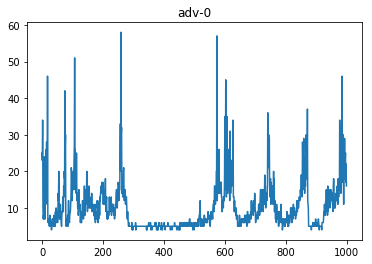

In [85]:
plt.plot(reward_all_0)
plt.title('adv-' + str(0))
plt.show()

### 5-4 TD(50) Advantage Actor-Critic

In [53]:
reward_all_50 = adv_ac(num_steps=50, max_episodes=1000)

Episode: 0, reward 20.0
Episode: 1, reward 20.0
Episode: 2, reward 13.0
Episode: 3, reward 14.0
Episode: 4, reward 29.0
Episode: 5, reward 14.0
Episode: 6, reward 31.0
Episode: 7, reward 10.0
Episode: 8, reward 15.0
Episode: 9, reward 27.0
Episode: 10, reward 16.0
Episode: 11, reward 12.0
Episode: 12, reward 23.0
Episode: 13, reward 13.0
Episode: 14, reward 24.0
Episode: 15, reward 17.0
Episode: 16, reward 11.0
Episode: 17, reward 20.0
Episode: 18, reward 14.0
Episode: 19, reward 10.0
Episode: 20, reward 29.0
Episode: 21, reward 15.0
Episode: 22, reward 16.0
Episode: 23, reward 53.0
Episode: 24, reward 21.0
Episode: 25, reward 11.0
Episode: 26, reward 25.0
Episode: 27, reward 15.0
Episode: 28, reward 21.0
Episode: 29, reward 47.0
Episode: 30, reward 26.0
Episode: 31, reward 18.0
Episode: 32, reward 25.0
Episode: 33, reward 20.0
Episode: 34, reward 11.0
Episode: 35, reward 22.0
Episode: 36, reward 25.0
Episode: 37, reward 36.0
Episode: 38, reward 32.0
Episode: 39, reward 24.0
Episode: 4

Episode: 323, reward 9.0
Episode: 324, reward 11.0
Episode: 325, reward 8.0
Episode: 326, reward 10.0
Episode: 327, reward 11.0
Episode: 328, reward 10.0
Episode: 329, reward 11.0
Episode: 330, reward 11.0
Episode: 331, reward 12.0
Episode: 332, reward 9.0
Episode: 333, reward 8.0
Episode: 334, reward 9.0
Episode: 335, reward 10.0
Episode: 336, reward 20.0
Episode: 337, reward 14.0
Episode: 338, reward 9.0
Episode: 339, reward 10.0
Episode: 340, reward 11.0
Episode: 341, reward 9.0
Episode: 342, reward 12.0
Episode: 343, reward 9.0
Episode: 344, reward 10.0
Episode: 345, reward 14.0
Episode: 346, reward 12.0
Episode: 347, reward 14.0
Episode: 348, reward 9.0
Episode: 349, reward 16.0
Episode: 350, reward 14.0
Episode: 351, reward 12.0
Episode: 352, reward 15.0
Episode: 353, reward 9.0
Episode: 354, reward 13.0
Episode: 355, reward 10.0
Episode: 356, reward 9.0
Episode: 357, reward 10.0
Episode: 358, reward 16.0
Episode: 359, reward 12.0
Episode: 360, reward 10.0
Episode: 361, reward 13

Episode: 640, reward 34.0
Episode: 641, reward 27.0
Episode: 642, reward 73.0
Episode: 643, reward 11.0
Episode: 644, reward 10.0
Episode: 645, reward 10.0
Episode: 646, reward 9.0
Episode: 647, reward 10.0
Episode: 648, reward 11.0
Episode: 649, reward 10.0
Episode: 650, reward 10.0
Episode: 651, reward 9.0
Episode: 652, reward 8.0
Episode: 653, reward 9.0
Episode: 654, reward 8.0
Episode: 655, reward 10.0
Episode: 656, reward 9.0
Episode: 657, reward 8.0
Episode: 658, reward 8.0
Episode: 659, reward 10.0
Episode: 660, reward 8.0
Episode: 661, reward 9.0
Episode: 662, reward 14.0
Episode: 663, reward 10.0
Episode: 664, reward 8.0
Episode: 665, reward 9.0
Episode: 666, reward 10.0
Episode: 667, reward 10.0
Episode: 668, reward 11.0
Episode: 669, reward 10.0
Episode: 670, reward 10.0
Episode: 671, reward 10.0
Episode: 672, reward 12.0
Episode: 673, reward 10.0
Episode: 674, reward 12.0
Episode: 675, reward 12.0
Episode: 676, reward 10.0
Episode: 677, reward 11.0
Episode: 678, reward 9.0

Episode: 962, reward 10.0
Episode: 963, reward 9.0
Episode: 964, reward 10.0
Episode: 965, reward 9.0
Episode: 966, reward 10.0
Episode: 967, reward 10.0
Episode: 968, reward 9.0
Episode: 969, reward 10.0
Episode: 970, reward 10.0
Episode: 971, reward 8.0
Episode: 972, reward 9.0
Episode: 973, reward 9.0
Episode: 974, reward 9.0
Episode: 975, reward 10.0
Episode: 976, reward 9.0
Episode: 977, reward 9.0
Episode: 978, reward 10.0
Episode: 979, reward 8.0
Episode: 980, reward 10.0
Episode: 981, reward 9.0
Episode: 982, reward 9.0
Episode: 983, reward 9.0
Episode: 984, reward 9.0
Episode: 985, reward 10.0
Episode: 986, reward 8.0
Episode: 987, reward 8.0
Episode: 988, reward 10.0
Episode: 989, reward 9.0
Episode: 990, reward 10.0
Episode: 991, reward 8.0
Episode: 992, reward 10.0
Episode: 993, reward 11.0
Episode: 994, reward 9.0
Episode: 995, reward 10.0
Episode: 996, reward 10.0
Episode: 997, reward 9.0
Episode: 998, reward 9.0
Episode: 999, reward 9.0


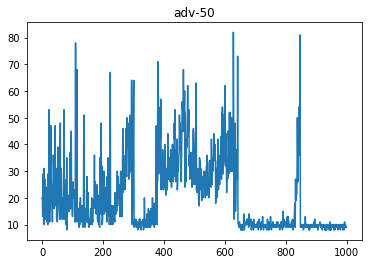

In [84]:
plt.plot(reward_all_50)
plt.title('adv-' + str(50))
plt.show()

### 5-5 TD(100) Advantage Actor-Critic

In [55]:
reward_all_100 = adv_ac(num_steps=100, max_episodes=1000)

Episode: 0, reward 16.0
Episode: 1, reward 16.0
Episode: 2, reward 42.0
Episode: 3, reward 42.0
Episode: 4, reward 36.0
Episode: 5, reward 12.0
Episode: 6, reward 29.0
Episode: 7, reward 27.0
Episode: 8, reward 19.0
Episode: 9, reward 29.0
Episode: 10, reward 12.0
Episode: 11, reward 20.0
Episode: 12, reward 17.0
Episode: 13, reward 21.0
Episode: 14, reward 17.0
Episode: 15, reward 12.0
Episode: 16, reward 27.0
Episode: 17, reward 19.0
Episode: 18, reward 16.0
Episode: 19, reward 11.0
Episode: 20, reward 36.0
Episode: 21, reward 21.0
Episode: 22, reward 34.0
Episode: 23, reward 15.0
Episode: 24, reward 23.0
Episode: 25, reward 14.0
Episode: 26, reward 17.0
Episode: 27, reward 46.0
Episode: 28, reward 50.0
Episode: 29, reward 11.0
Episode: 30, reward 12.0
Episode: 31, reward 15.0
Episode: 32, reward 16.0
Episode: 33, reward 25.0
Episode: 34, reward 37.0
Episode: 35, reward 21.0
Episode: 36, reward 19.0
Episode: 37, reward 33.0
Episode: 38, reward 45.0
Episode: 39, reward 13.0
Episode: 4

Episode: 327, reward 8.0
Episode: 328, reward 10.0
Episode: 329, reward 10.0
Episode: 330, reward 10.0
Episode: 331, reward 11.0
Episode: 332, reward 8.0
Episode: 333, reward 10.0
Episode: 334, reward 9.0
Episode: 335, reward 9.0
Episode: 336, reward 9.0
Episode: 337, reward 10.0
Episode: 338, reward 8.0
Episode: 339, reward 9.0
Episode: 340, reward 9.0
Episode: 341, reward 9.0
Episode: 342, reward 9.0
Episode: 343, reward 9.0
Episode: 344, reward 10.0
Episode: 345, reward 9.0
Episode: 346, reward 9.0
Episode: 347, reward 8.0
Episode: 348, reward 9.0
Episode: 349, reward 9.0
Episode: 350, reward 10.0
Episode: 351, reward 9.0
Episode: 352, reward 9.0
Episode: 353, reward 10.0
Episode: 354, reward 10.0
Episode: 355, reward 9.0
Episode: 356, reward 8.0
Episode: 357, reward 10.0
Episode: 358, reward 9.0
Episode: 359, reward 10.0
Episode: 360, reward 8.0
Episode: 361, reward 9.0
Episode: 362, reward 10.0
Episode: 363, reward 10.0
Episode: 364, reward 9.0
Episode: 365, reward 11.0
Episode: 3

Episode: 658, reward 11.0
Episode: 659, reward 14.0
Episode: 660, reward 17.0
Episode: 661, reward 10.0
Episode: 662, reward 14.0
Episode: 663, reward 18.0
Episode: 664, reward 12.0
Episode: 665, reward 10.0
Episode: 666, reward 12.0
Episode: 667, reward 12.0
Episode: 668, reward 17.0
Episode: 669, reward 10.0
Episode: 670, reward 12.0
Episode: 671, reward 9.0
Episode: 672, reward 14.0
Episode: 673, reward 13.0
Episode: 674, reward 12.0
Episode: 675, reward 15.0
Episode: 676, reward 13.0
Episode: 677, reward 20.0
Episode: 678, reward 11.0
Episode: 679, reward 17.0
Episode: 680, reward 16.0
Episode: 681, reward 16.0
Episode: 682, reward 18.0
Episode: 683, reward 17.0
Episode: 684, reward 11.0
Episode: 685, reward 14.0
Episode: 686, reward 11.0
Episode: 687, reward 15.0
Episode: 688, reward 16.0
Episode: 689, reward 29.0
Episode: 690, reward 14.0
Episode: 691, reward 22.0
Episode: 692, reward 24.0
Episode: 693, reward 22.0
Episode: 694, reward 11.0
Episode: 695, reward 14.0
Episode: 696,

Episode: 981, reward 19.0
Episode: 982, reward 15.0
Episode: 983, reward 13.0
Episode: 984, reward 19.0
Episode: 985, reward 12.0
Episode: 986, reward 14.0
Episode: 987, reward 15.0
Episode: 988, reward 12.0
Episode: 989, reward 13.0
Episode: 990, reward 12.0
Episode: 991, reward 14.0
Episode: 992, reward 16.0
Episode: 993, reward 11.0
Episode: 994, reward 12.0
Episode: 995, reward 14.0
Episode: 996, reward 16.0
Episode: 997, reward 16.0
Episode: 998, reward 11.0
Episode: 999, reward 15.0


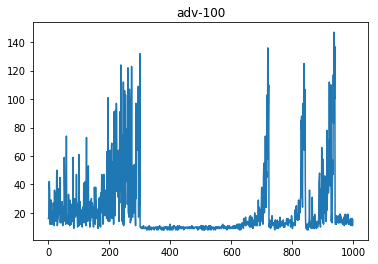

In [83]:
plt.plot(reward_all_100)
plt.title('adv-' + str(100))
plt.show()

### 5-6 TD(150) Advantage Actor-Critic

In [57]:
reward_all_150 = adv_ac(num_steps=150, max_episodes=1000)

Episode: 0, reward 17.0
Episode: 1, reward 18.0
Episode: 2, reward 10.0
Episode: 3, reward 16.0
Episode: 4, reward 25.0
Episode: 5, reward 24.0
Episode: 6, reward 15.0
Episode: 7, reward 20.0
Episode: 8, reward 14.0
Episode: 9, reward 17.0
Episode: 10, reward 13.0
Episode: 11, reward 19.0
Episode: 12, reward 15.0
Episode: 13, reward 14.0
Episode: 14, reward 27.0
Episode: 15, reward 14.0
Episode: 16, reward 14.0
Episode: 17, reward 55.0
Episode: 18, reward 12.0
Episode: 19, reward 22.0
Episode: 20, reward 18.0
Episode: 21, reward 24.0
Episode: 22, reward 19.0
Episode: 23, reward 17.0
Episode: 24, reward 20.0
Episode: 25, reward 18.0
Episode: 26, reward 19.0
Episode: 27, reward 10.0
Episode: 28, reward 25.0
Episode: 29, reward 67.0
Episode: 30, reward 13.0
Episode: 31, reward 13.0
Episode: 32, reward 14.0
Episode: 33, reward 21.0
Episode: 34, reward 19.0
Episode: 35, reward 14.0
Episode: 36, reward 23.0
Episode: 37, reward 10.0
Episode: 38, reward 12.0
Episode: 39, reward 45.0
Episode: 4

Episode: 325, reward 12.0
Episode: 326, reward 28.0
Episode: 327, reward 12.0
Episode: 328, reward 25.0
Episode: 329, reward 36.0
Episode: 330, reward 14.0
Episode: 331, reward 11.0
Episode: 332, reward 19.0
Episode: 333, reward 12.0
Episode: 334, reward 9.0
Episode: 335, reward 11.0
Episode: 336, reward 12.0
Episode: 337, reward 22.0
Episode: 338, reward 16.0
Episode: 339, reward 30.0
Episode: 340, reward 17.0
Episode: 341, reward 52.0
Episode: 342, reward 16.0
Episode: 343, reward 32.0
Episode: 344, reward 38.0
Episode: 345, reward 16.0
Episode: 346, reward 14.0
Episode: 347, reward 26.0
Episode: 348, reward 21.0
Episode: 349, reward 59.0
Episode: 350, reward 62.0
Episode: 351, reward 40.0
Episode: 352, reward 15.0
Episode: 353, reward 11.0
Episode: 354, reward 16.0
Episode: 355, reward 15.0
Episode: 356, reward 15.0
Episode: 357, reward 21.0
Episode: 358, reward 94.0
Episode: 359, reward 21.0
Episode: 360, reward 18.0
Episode: 361, reward 9.0
Episode: 362, reward 16.0
Episode: 363, 

Episode: 642, reward 23.0
Episode: 643, reward 28.0
Episode: 644, reward 15.0
Episode: 645, reward 12.0
Episode: 646, reward 26.0
Episode: 647, reward 36.0
Episode: 648, reward 20.0
Episode: 649, reward 39.0
Episode: 650, reward 19.0
Episode: 651, reward 8.0
Episode: 652, reward 14.0
Episode: 653, reward 30.0
Episode: 654, reward 49.0
Episode: 655, reward 34.0
Episode: 656, reward 25.0
Episode: 657, reward 23.0
Episode: 658, reward 20.0
Episode: 659, reward 13.0
Episode: 660, reward 10.0
Episode: 661, reward 21.0
Episode: 662, reward 35.0
Episode: 663, reward 12.0
Episode: 664, reward 14.0
Episode: 665, reward 27.0
Episode: 666, reward 16.0
Episode: 667, reward 12.0
Episode: 668, reward 33.0
Episode: 669, reward 31.0
Episode: 670, reward 16.0
Episode: 671, reward 33.0
Episode: 672, reward 24.0
Episode: 673, reward 25.0
Episode: 674, reward 16.0
Episode: 675, reward 14.0
Episode: 676, reward 30.0
Episode: 677, reward 30.0
Episode: 678, reward 28.0
Episode: 679, reward 15.0
Episode: 680,

Episode: 958, reward 48.0
Episode: 959, reward 12.0
Episode: 960, reward 13.0
Episode: 961, reward 45.0
Episode: 962, reward 33.0
Episode: 963, reward 38.0
Episode: 964, reward 12.0
Episode: 965, reward 15.0
Episode: 966, reward 13.0
Episode: 967, reward 10.0
Episode: 968, reward 24.0
Episode: 969, reward 29.0
Episode: 970, reward 12.0
Episode: 971, reward 14.0
Episode: 972, reward 37.0
Episode: 973, reward 11.0
Episode: 974, reward 12.0
Episode: 975, reward 30.0
Episode: 976, reward 28.0
Episode: 977, reward 10.0
Episode: 978, reward 23.0
Episode: 979, reward 22.0
Episode: 980, reward 28.0
Episode: 981, reward 22.0
Episode: 982, reward 22.0
Episode: 983, reward 18.0
Episode: 984, reward 29.0
Episode: 985, reward 11.0
Episode: 986, reward 12.0
Episode: 987, reward 13.0
Episode: 988, reward 17.0
Episode: 989, reward 25.0
Episode: 990, reward 26.0
Episode: 991, reward 45.0
Episode: 992, reward 18.0
Episode: 993, reward 19.0
Episode: 994, reward 26.0
Episode: 995, reward 12.0
Episode: 996

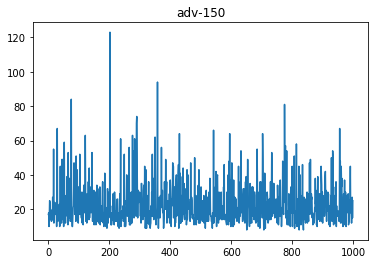

In [82]:
plt.plot(reward_all_150)
plt.title('adv-' + str(150))
plt.show()

### 5-7 Monte Carlo [TD(200)] Advantage Actor-Critic

In [59]:
reward_all_200 = adv_ac(num_steps=200, max_episodes=1000)

Episode: 0, reward 22.0
Episode: 1, reward 18.0
Episode: 2, reward 12.0
Episode: 3, reward 25.0
Episode: 4, reward 15.0
Episode: 5, reward 32.0
Episode: 6, reward 16.0
Episode: 7, reward 17.0
Episode: 8, reward 52.0
Episode: 9, reward 30.0
Episode: 10, reward 11.0
Episode: 11, reward 18.0
Episode: 12, reward 14.0
Episode: 13, reward 12.0
Episode: 14, reward 42.0
Episode: 15, reward 55.0
Episode: 16, reward 25.0
Episode: 17, reward 46.0
Episode: 18, reward 18.0
Episode: 19, reward 35.0
Episode: 20, reward 9.0
Episode: 21, reward 36.0
Episode: 22, reward 12.0
Episode: 23, reward 13.0
Episode: 24, reward 12.0
Episode: 25, reward 42.0
Episode: 26, reward 12.0
Episode: 27, reward 17.0
Episode: 28, reward 23.0
Episode: 29, reward 30.0
Episode: 30, reward 38.0
Episode: 31, reward 12.0
Episode: 32, reward 18.0
Episode: 33, reward 15.0
Episode: 34, reward 14.0
Episode: 35, reward 19.0
Episode: 36, reward 19.0
Episode: 37, reward 11.0
Episode: 38, reward 33.0
Episode: 39, reward 33.0
Episode: 40

Episode: 316, reward 95.0
Episode: 317, reward 134.0
Episode: 318, reward 146.0
Episode: 319, reward 200.0
Episode: 320, reward 200.0
Episode: 321, reward 133.0
Episode: 322, reward 200.0
Episode: 323, reward 200.0
Episode: 324, reward 200.0
Episode: 325, reward 200.0
Episode: 326, reward 200.0
Episode: 327, reward 200.0
Episode: 328, reward 200.0
Episode: 329, reward 200.0
Episode: 330, reward 200.0
Episode: 331, reward 200.0
Episode: 332, reward 200.0
Episode: 333, reward 200.0
Episode: 334, reward 200.0
Episode: 335, reward 200.0
Episode: 336, reward 200.0
Episode: 337, reward 200.0
Episode: 338, reward 200.0
Episode: 339, reward 200.0
Episode: 340, reward 200.0
Episode: 341, reward 200.0
Episode: 342, reward 200.0
Episode: 343, reward 200.0
Episode: 344, reward 200.0
Episode: 345, reward 200.0
Episode: 346, reward 125.0
Episode: 347, reward 123.0
Episode: 348, reward 200.0
Episode: 349, reward 177.0
Episode: 350, reward 163.0
Episode: 351, reward 193.0
Episode: 352, reward 120.0
Ep

Episode: 621, reward 192.0
Episode: 622, reward 165.0
Episode: 623, reward 200.0
Episode: 624, reward 200.0
Episode: 625, reward 200.0
Episode: 626, reward 200.0
Episode: 627, reward 200.0
Episode: 628, reward 171.0
Episode: 629, reward 153.0
Episode: 630, reward 161.0
Episode: 631, reward 191.0
Episode: 632, reward 179.0
Episode: 633, reward 191.0
Episode: 634, reward 186.0
Episode: 635, reward 171.0
Episode: 636, reward 172.0
Episode: 637, reward 154.0
Episode: 638, reward 185.0
Episode: 639, reward 200.0
Episode: 640, reward 200.0
Episode: 641, reward 177.0
Episode: 642, reward 168.0
Episode: 643, reward 200.0
Episode: 644, reward 200.0
Episode: 645, reward 200.0
Episode: 646, reward 200.0
Episode: 647, reward 174.0
Episode: 648, reward 164.0
Episode: 649, reward 136.0
Episode: 650, reward 151.0
Episode: 651, reward 148.0
Episode: 652, reward 130.0
Episode: 653, reward 128.0
Episode: 654, reward 130.0
Episode: 655, reward 146.0
Episode: 656, reward 105.0
Episode: 657, reward 125.0
E

Episode: 925, reward 147.0
Episode: 926, reward 126.0
Episode: 927, reward 144.0
Episode: 928, reward 133.0
Episode: 929, reward 145.0
Episode: 930, reward 113.0
Episode: 931, reward 126.0
Episode: 932, reward 123.0
Episode: 933, reward 105.0
Episode: 934, reward 97.0
Episode: 935, reward 30.0
Episode: 936, reward 103.0
Episode: 937, reward 110.0
Episode: 938, reward 113.0
Episode: 939, reward 29.0
Episode: 940, reward 115.0
Episode: 941, reward 111.0
Episode: 942, reward 118.0
Episode: 943, reward 126.0
Episode: 944, reward 138.0
Episode: 945, reward 121.0
Episode: 946, reward 137.0
Episode: 947, reward 119.0
Episode: 948, reward 119.0
Episode: 949, reward 147.0
Episode: 950, reward 145.0
Episode: 951, reward 152.0
Episode: 952, reward 136.0
Episode: 953, reward 119.0
Episode: 954, reward 142.0
Episode: 955, reward 124.0
Episode: 956, reward 133.0
Episode: 957, reward 136.0
Episode: 958, reward 122.0
Episode: 959, reward 117.0
Episode: 960, reward 118.0
Episode: 961, reward 129.0
Epis

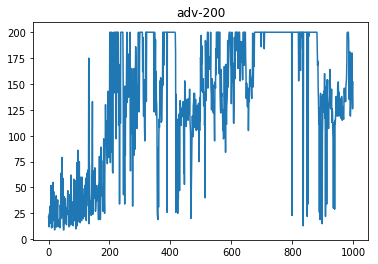

In [81]:
plt.plot(reward_all_200)
plt.title('adv-' + str(200))
plt.show()